# sir convencional - modelo de base

In [1]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
plt.style.use('seaborn')

In [2]:
# The SIR model differential equations.
def deriv(y, t, N, beta, gamma):
    S, I, R = y
    dSdt = -beta * S * I / N
    dIdt = beta * S * I / N - gamma * I
    dRdt = gamma * I
    return dSdt, dIdt, dRdt

In [3]:
# The new SIRA model differential equations.
def deriv2(y, t, N, beta0, alpha, gamma):
    S, I, R, A = y
    dSdt = (-(beta0 - A*alpha)* S * I)/N
    dIdt = A
    dRdt = gamma * I #esta sigue igual, esta ok 
    div = 1 + alpha*S*(I/N)
    t1 = -S*(I/N)*(I/N)*((beta0 - A*alpha)**2)
    t2 = (beta0 - A*alpha)*S*(A/N)
    t3 = -gamma*A
    dAdt = (1/div) * (t1 + t2 + t3)
    return dSdt, dIdt, dRdt, dAdt

In [4]:
def sum_last14(casos_por_dia):
    #latest update = checked the days again, it works perfectly splendid
    ac_por_dia = np.copy(casos_por_dia)
    casos_por_dia = casos_por_dia.reshape(-1,1)
    dias = np.arange(casos_por_dia.shape[0])
    dias = dias.reshape(-1,1)
    casos_por_dia = np.hstack([dias,casos_por_dia])
    for i in casos_por_dia[:,0]:
        i = int(i)
        index = np.copy(casos_por_dia[casos_por_dia[:,0]<i+1])
        index = index[i-13<=index[:,0]]
        index = index[:,1]
        ac_por_dia[i] = np.sum(index) 
    return ac_por_dia

In [34]:
def error(new_cases_per_day,r_t_seven,riesgo,n):
    a_t = sum_last14(np.copy(new_cases_per_day))*(100000/n)
    np.savetxt('sirmod_2.txt',np.c_[a_t,r_t_seven,riesgo],delimiter=',')

# sir modificado 

In [31]:
def sir_modificado(b0,a,g,i0,r0,a0,n,dias):
    # Total population, N.
    N = n
    # Initial number of infected and recovered individuals, I0 and R0.
    I0, R0, A0 = i0, r0, a0
    # Everyone else, S0, is susceptible to infection initially.
    S0 = N - I0 - R0
    # Contact rate, beta, and mean recovery rate, gamma, (in 1/days).
    beta, alpha, gamma = b0,a,g
    # A grid of time points (in days)
    t = np.linspace(0, dias, dias)

    # Initial conditions vector
    y0 = S0, I0, R0, A0
    # Integrate the SIR equations over the time grid, t.
    ret = odeint(deriv2, y0, t, args=(N, beta, alpha, gamma))
    S, I, R, A = ret.T

    # Plot the data on three separate curves for S(t), I(t) and R(t)
    fig = plt.figure()
    #plt.title('SIR modificado')
    ax = fig.add_subplot(111, axisbelow=True)
    plt.title('SIR modificado')
    ax.plot(t, S/n, 'b', alpha=0.5, lw=2, label='Susceptible')
    ax.plot(t, I/n, 'r', alpha=0.5, lw=2, label='Infected')
    ax.plot(t, R/n, 'g', alpha=0.5, lw=2, label='Recovered with immunity')
    ax.set_xlabel('Time /days')
    ax.set_ylabel('Number (1000s)')
    ax.set_ylim(0,1.2)
    ax.yaxis.set_tick_params(length=0)
    ax.xaxis.set_tick_params(length=0)
    ax.grid(b=True, which='major', c='w', lw=2, ls='-')
    legend = ax.legend()
    legend.get_frame().set_alpha(0.5)
    for spine in ('top', 'right', 'bottom', 'left'):
        ax.spines[spine].set_visible(False)
    plt.show()
    n_t = -np.diff(S)
    n_t = np.hstack((0,n_t))
    n_t = n_t.astype(int)
    new_cases_per_day = np.copy(n_t)
    prox_dia = n_t.shape[0]
    a = np.zeros(6) + 1.0
    aux = np.zeros(1)
    i = 0
    while i < 4: #completing until the day t+4 bc im gonna need it later for averaging in 7 days
        aux = np.mean(n_t[prox_dia-7:])
        n_t  = np.hstack((n_t,aux)) #extending n_t up to day t+1
        i= i +1
    r_t = np.zeros(n_t.shape,dtype=float) #here we will store the rt
    dias_aux = np.arange(0,prox_dia+3)
    for i in dias_aux[dias_aux>=6]:
        aux = a[0]*n_t[i-6] + a[1]*n_t[i-5] + a[2]*n_t[i-4] #denominator of the r_t expression
        if(aux==0):
            aux = 1 #the first cases in which the denominator is == 0
        r_t[i] = min(((a[3]*n_t[i-1] + a[4]*n_t[i] + a[5]*n_t[i+1])/(aux)),4) #the rest of the days with limit value
    r_t_seven = np.zeros(prox_dia) #real values for index>=9
    i = 9
    while i < prox_dia:
        r_t_seven[i] = np.mean(r_t[i-3:i+4])
        i = i+1
    plt.title('SIR modificado')
    plt.plot(r_t_seven[9:])
    plt.axhline(y=1,c='r')
    plt.xlabel('Time/days')
    plt.ylabel('R7')
    plt.show()
    #now we start with the risk diagram 
    a_t = np.zeros(prox_dia) #real values for index >= 13
    i = 13
    while i < prox_dia:
        a_t[i] = np.sum(n_t[i-13:i+1]) 
        i = i+1
    a_t = a_t * (100000/n) #where n is the population of the simulation
    riesgo = a_t * r_t_seven
    plt.title('SIR modificado')
    plt.plot(a_t[13:],r_t_seven[13:],'-or',markersize=5)
    plt.show()
    return new_cases_per_day,r_t_seven,riesgo #return new cases per day, risk

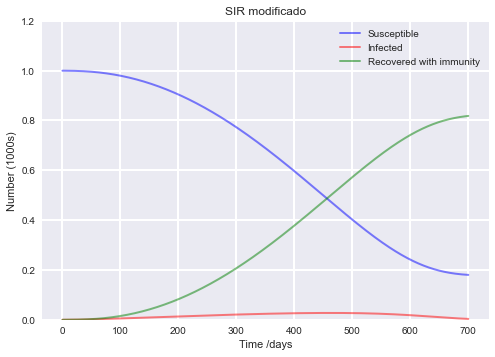

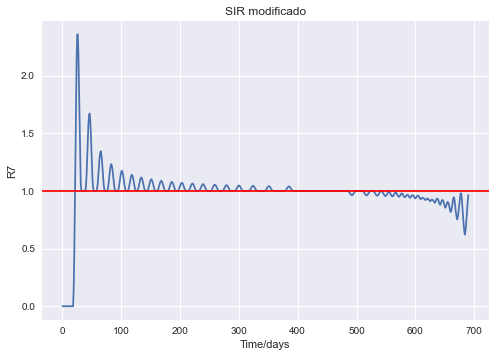

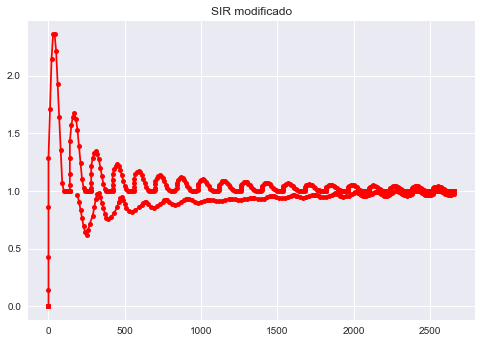

In [35]:
n = 10000
i0, r0, a0 = 1, 0, 0.1
b0,a,g = 0.15, 0.08,  1./14 
dias = 700
new_cases_per_day,r_t_seven,riesgo =sir_modificado(b0,a,g,i0,r0,a0,n,dias)

In [36]:
error(new_cases_per_day,r_t_seven,riesgo,n)

# sir convencional

In [18]:
def sir(b0,g,i0,r0,n,dias):
    # Total population, N.
    N = n
    # Initial number of infected and recovered individuals, I0 and R0.
    I0, R0 = i0, r0
    # Everyone else, S0, is susceptible to infection initially.
    S0 = N - I0 - R0
    # Contact rate, beta, and mean recovery rate, gamma, (in 1/days).
    beta, gamma = b0, g
    # A grid of time points (in days)
    t = np.linspace(0, dias, dias)

    # Initial conditions vector
    y0 = S0, I0, R0
    # Integrate the SIR equations over the time grid, t.
    ret = odeint(deriv, y0, t, args=(N, beta, gamma))
    S, I, R = ret.T

    # Plot the data on three separate curves for S(t), I(t) and R(t)
    fig = plt.figure()
    ax = fig.add_subplot(111, axisbelow=True)
    plt.title('SIR común')
    ax.plot(t, S/n, 'b', alpha=0.5, lw=2, label='Susceptible')
    ax.plot(t, I/n, 'r', alpha=0.5, lw=2, label='Infected')
    ax.plot(t, R/n, 'g', alpha=0.5, lw=2, label='Recovered with immunity')
    ax.set_xlabel('Time /days')
    ax.set_ylabel('Number (1000s)')
    ax.set_ylim(0,1.2)
    ax.yaxis.set_tick_params(length=0)
    ax.xaxis.set_tick_params(length=0)
    ax.grid(b=True, which='major', c='w', lw=2, ls='-')
    legend = ax.legend()
    legend.get_frame().set_alpha(0.5)
    for spine in ('top', 'right', 'bottom', 'left'):
        ax.spines[spine].set_visible(False)
    plt.show()
    n_t = -np.diff(S)
    n_t = np.hstack((0,n_t))
    n_t = n_t.astype(int)
    new_cases_per_day = np.copy(n_t)
    prox_dia = n_t.shape[0]
    a = np.zeros(6) + 1.0
    aux = np.zeros(1)
    i = 0
    while i < 4: #completing until the day t+4 bc im gonna need it later for averaging in 7 days
        aux = np.mean(n_t[prox_dia-7:])
        n_t  = np.hstack((n_t,aux)) #extending n_t up to day t+1
        i= i +1
    r_t = np.zeros(n_t.shape,dtype=float) #here we will store the rt
    dias_aux = np.arange(0,prox_dia+3)
    for i in dias_aux[dias_aux>=6]:
        aux = a[0]*n_t[i-6] + a[1]*n_t[i-5] + a[2]*n_t[i-4] #denominator of the r_t expression
        if(aux==0):
            aux = 1 #the first cases in which the denominator is == 0
        r_t[i] = min(((a[3]*n_t[i-1] + a[4]*n_t[i] + a[5]*n_t[i+1])/(aux)),4) #the rest of the days with limit value
    r_t_seven = np.zeros(prox_dia) #real values for index>=9
    i = 9
    while i < prox_dia:
        r_t_seven[i] = np.mean(r_t[i-3:i+4])
        i = i+1
    plt.title('SIR común')
    plt.plot(r_t_seven[9:])
    plt.axhline(y=1,c='r')
    plt.xlabel('Time/days')
    plt.ylabel('R7')
    plt.show()
    #now we start with the risk diagram 
    a_t = np.zeros(prox_dia) #real values for index >= 13
    i = 13
    while i < prox_dia:
        a_t[i] = np.sum(n_t[i-13:i+1]) 
        i = i+1
    a_t = a_t * (100000/n) #where n is the population of the simulation
    riesgo = a_t * r_t_seven
    plt.plot(a_t[13:],r_t_seven[13:],'-or',markersize=5)
    plt.show()
    return new_cases_per_day,r_t_seven,riesgo #return new cases per day, risk

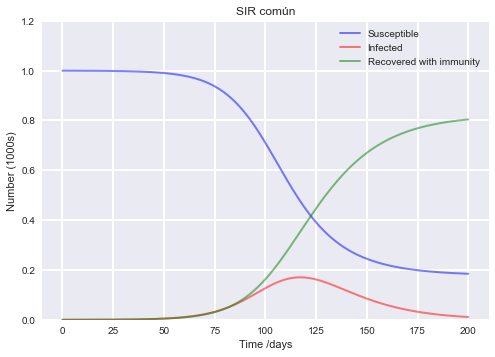

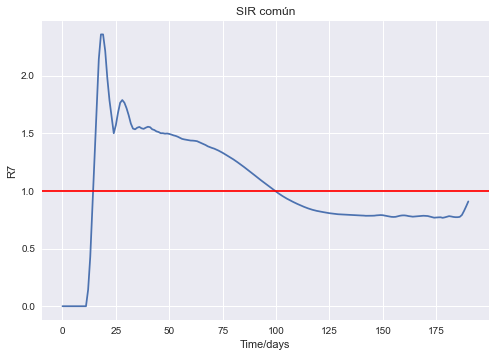

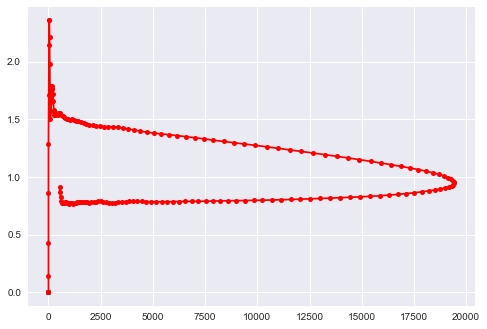

In [23]:
n = 10000
i0, r0  = 1, 0
b0,g = 0.15, 1./14 
dias = 200
new_cases_per_day,r_t_seven,riesgo = sir(b0,g,i0,r0,n,dias)

In [24]:
error(new_cases_per_day,r_t_seven,riesgo,n)